In [1]:
from bs4 import BeautifulSoup
import requests
from urllib.parse import urlparse, quote
import urllib.request
import os
import pypdf
from collections import deque
import io
import re
from html.parser import HTMLParser
from qdrant_client import QdrantClient
import pandas as pd
from dotenv import load_dotenv
load_dotenv()
import uuid
from qdrant_client import models
from langchain.vectorstores.qdrant import Qdrant
from qdrant_client.models import Distance, VectorParams
from httpx import Timeout
from langchain.prompts import PromptTemplate
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains import create_retrieval_chain
import google.generativeai as genai
from langchain_google_genai import GoogleGenerativeAIEmbeddings

To crawl the webpage, I made use of the code mentioned in the OpenAI cookbook: https://github.com/openai/openai-cookbook/blob/main/apps/web-crawl-q-and-a/web-qa.ipynb?ref=mlq.ai

# RAG Implementation Comparison: Custom vs. LangChain

## Overview

In this notebook, I've implemented two versions of Retrieval-Augmented Generation (RAG):

1. A custom implementation built from scratch
2. An implementation using LangChain

## Key Findings

### Custom Implementation
- Built entirely from scratch
- Offers more control over the process
- Resulted in a more manageable size for Lambda deployment

### LangChain Implementation
- Utilized the LangChain library for RAG
- Provided pre-built components and easier setup
- Resulted in significantly larger deployment size

## Deployment Challenges

When attempting to deploy these implementations to AWS Lambda, I encountered notable differences:

- **Custom Implementation**: Successfully deployed within Lambda's size limits
- **LangChain Implementation**: Faced size-related errors during deployment

### Note on Multiple Layers
While I'm aware of the possibility of using multiple layers in Lambda to accommodate larger dependencies, this approach provided minimal improvements for the LangChain implementation. The size reduction was not significant enough to justify the added complexity of managing multiple layers.

## Conclusion

For my use case, the custom RAG implementation proved more suitable for Lambda deployment due to its smaller size footprint. While LangChain offers convenience and pre-built components, its size makes it challenging to deploy in serverless environments like Lambda without significant compromises.

The trade-off between development ease (LangChain) and deployment simplicity (custom implementation) is evident. For Lambda-based deployments, the custom approach appears to be more practical and cost-effective in the long run.

In [ ]:

# Regex pattern 
HTTP_URL_PATTERN = r'^http[s]*://.+'

# Define domain
domain = "ashoka.edu.in"
full_url = "https://ashoka.edu.in/"

# Create the class to parse the hyperlinks
class HyperlinkParser(HTMLParser):
    def __init__(self):
        super().__init__()
        self.hyperlinks = []

    # Overriding the existing functions
    def handle_starttag(self, tag, attrs):
        attrs = dict(attrs)
        if tag == "a" and "href" in attrs:
            self.hyperlinks.append(attrs["href"])


def get_hyperlinks(url):

    try:
        with urllib.request.urlopen(url) as response:
            if not response.info().get('Content-Type').startswith("text/html"):
                return []
            html = response.read().decode('utf-8')
    except Exception as e:
        print(e)
        return []

    parser = HyperlinkParser()
    parser.feed(html)

    return parser.hyperlinks

# Function to get the hyperlinks from a URL that are within the same domain
def get_domain_hyperlinks(local_domain, url):
    clean_links = []
    for link in set(get_hyperlinks(url)):
        clean_link = None

        # If the link is a URL, check if it is within the same domain
        if re.search(HTTP_URL_PATTERN, link):
            # Parse the URL and check if the domain is the same
            url_obj = urlparse(link)
            if url_obj.netloc == local_domain:
                clean_link = link

        # If the link is not a URL, check if it is a relative link
        else:
            if link.startswith("/"):
                link = link[1:]
            elif link.startswith("#") or link.startswith("mailto:"):
                continue
            clean_link = "https://" + local_domain + "/" + link

        if clean_link is not None:
            if clean_link.endswith("/"):
                clean_link = clean_link[:-1]
            clean_links.append(clean_link)

    # Return the list of hyperlinks that are within the same domain
    return list(set(clean_links))

def pdf_to_text(pdf_content):
    # Create a PDF file object from the PDF content
    pdf_file = io.BytesIO(pdf_content)

    # Create a PDF reader object
    pdf_reader = pypdf.PdfReader(pdf_file)

    # Extract text from each page of the PDF
    text = ""
    i = 0 
    print(len(pdf_reader.pages))

    for page in range(len(pdf_reader.pages)):
        text += pdf_reader.pages[i].extract_text()
        i=i+1

    return text

def crawl(url):
    # Parse the URL and get the domain
    local_domain = urlparse(url).netloc

    # Create a queue to store the URLs to crawl
    queue = deque([url])

    # Create a set to store the URLs that have already been seen (no duplicates)
    seen = set([url])

    # Create a directory to store the text files
    if not os.path.exists("text/"):
        os.mkdir("text/")

    if not os.path.exists("text/" + local_domain + "/"):
        os.mkdir("text/" + local_domain + "/")

    # Create a directory to store the csv files
    if not os.path.exists("processed"):
        os.mkdir("processed")

    # Define the header tags to ignore while extracting text
    header_tags = ['h1', 'h2', 'h3', 'h4', 'h5', 'h6']

    # While the queue is not empty, continue crawling
    while queue:
        # Get the next URL from the queue
        url = queue.pop()
        print(url)  # for debugging and to see the progress

        response = requests.get(url)

        # Sanitize the URL to create a valid filename
        sanitized_url = quote(url, safe='')

        # Save text from the URL to a <url>.txt file
        with open('text/' + local_domain + '/' + sanitized_url + ".txt", "w", encoding="utf-8") as f:
            # Get the text from the URL using BeautifulSoup
            if response.headers.get('Content-Type') == ("application/pdf"):
                pdf_text = pdf_to_text(response.content)
                f.write(pdf_text)
            else:
                soup = BeautifulSoup(requests.get(url).text, "html.parser")

                # Remove header tags and anchor tags with titles from the soup object
                for tag in soup.find_all(header_tags):
                    tag.extract()
                for tag in soup.find_all('a', {'title': True}):
                    tag.extract()

                # Remove the text content within anchor tags but keep the anchor tags
                for tag in soup.find_all('a'):
                    tag.string = ''  # Set the text content within anchor tags to an empty string

                # Get the text from the soup object but preserve the text within span tags
                text = ""
                for tag in soup.find_all(string=True):
                    if tag.parent.name != 'span':
                        text += tag



                # Get the text but remove the remaining tags
                text = soup.get_text()

                # If the crawler gets to a page that requires JavaScript, it will stop the crawl
                if "You need to enable JavaScript to run this app." in text:
                    print("Unable to parse page " + url + " due to JavaScript being required")

                # Otherwise, write the text to the file in the text directory
                f.write(text)

        # Get the hyperlinks from the URL and add them to the queue
        for link in get_domain_hyperlinks(local_domain, url):
            if link not in seen:
                queue.append(link)
                seen.add(link)

crawl(full_url)



In [2]:
def remove_newlines(serie):
    serie = serie.str.replace('\n', ' ')
    serie = serie.str.replace('\\n', ' ')
    serie = serie.str.replace('  ', ' ')
    serie = serie.str.replace('  ', ' ')
    return serie

In [4]:
texts = []

for file in os.listdir("text/ashoka.edu.in/"):
    with open("text/ashoka.edu.in/" + file, "r" , encoding="utf-8") as f:
        text = f.read()
        texts.append(text)

df = pd.DataFrame(texts, columns = ['text'])
df['text'] = remove_newlines(df.text)
df['id'] = [uuid.uuid4() for _ in range(len(df))]
df.to_csv('processed/scraped2.csv', escapechar="\\")
df.head()



,text,id
0,Chemistry Handbook GUIDELINES FOR STUDENTS ...,bd86ad87-9464-472e-a7dc-c29b4a644ee1
1,1 POLITICAL SCIENCE HANDBOOK GUIDELINES F...,f74e5d92-118e-4300-9f09-6b4870d3a7c4
2,Chemistry Handbook GUIDELINES FOR STUDENTS ...,7190f52a-bae6-48ac-98d0-06a14fad625f
3,Department of BIOLOGICAL SCIENCESDepartment of...,a59b307e-206e-49e0-8792-f5543bccf964
4,Students’ Guide Department of Computer Science...,112053ab-2c9e-44de-a702-fb918ddae63f


<Axes: >

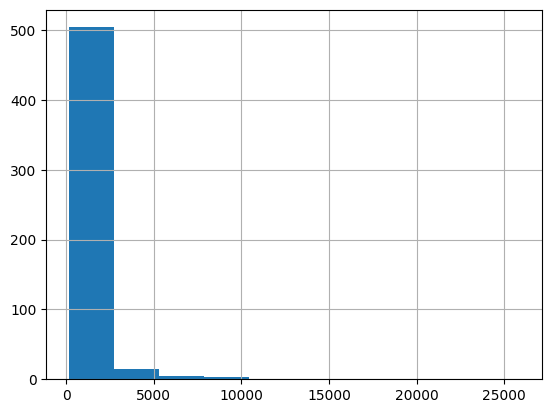

In [5]:
import tiktoken
tokenizer = tiktoken.get_encoding("cl100k_base")
df = pd.read_csv("processed/scraped2.csv", index_col= 0)
df.columns = ['text', 'id']
df = df[pd.notna(df['text'])]
df['no_tokens'] = df.text.apply(lambda x : len(tokenizer.encode(x)))
df['no_tokens'].hist()

In [37]:
#Just to save the emebddings on to the disk
import google.generativeai as genai
import pandas as pd
import numpy as np
import uuid

def embed_texts_in_batches(texts, batch_size=5, model="models/embedding-001"):
    embeddings_list = []
    texts = [str(text) for text in texts if not isinstance(text, float) or not np.isnan(text)]
    # Split texts into batches
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        embeddings_batch = embed_batch(batch_texts, model=model)
        embeddings_list.extend(embeddings_batch)

    return pd.DataFrame({"text": texts, "embedding": embeddings_list, "id" :[uuid.uuid4() for _ in range(len(texts))]})

def embed_batch(texts, model):
    return genai.embed_content(
            model=model,
            content=texts,
            task_type="retrieval_document"
        )['embedding']
  

texts = df['text'].tolist()
embeddings_df = embed_texts_in_batches(texts, batch_size=5)
embeddings_df.to_csv('processed/final.csv', index=False)  
print(embeddings_df)

                                                  text  \
0    Chemistry Handbook    GUIDELINES FOR STUDENTS ...   
1     The core (theory) courses are:  • Energetics ...   
2    For 1000/2000 level courses like ‘Chemistry fo...   
3    These are all 3000 level courses  • Basic Inor...   
4     2. Can laboratory courses be counted as an el...   
..                                                 ...   
903  For completing a major in Sociology and Anthro...   
904  For completing a minor, a student has to take ...   
905     Courses to be offered in Monsoon Semester 2...   
906  These will        be intensive weekly sessions...   
907   Q: Is it mandatory for majors to finish 1101 ...   

                                             embedding  \
0    [0.041855942, -0.019184085, -0.04255649, -0.04...   
1    [0.04032769, -0.00032470832, -0.02137377, -0.0...   
2    [0.032604985, -0.039614826, -0.05501883, -0.03...   
3    [0.03609055, -0.02177331, -0.046362255, -0.044...   
4    [0.07617

In [8]:
#initialise the connection to the vector store, recreating the collection.
from qdrant_client import QdrantClient
client = QdrantClient(
    url=os.getenv('QDRANT_HOST'),
    api_key=os.getenv('QDRANT_API_KEY'),
)

client.recreate_collection(
    collection_name= 'University_assistant', vectors_config= VectorParams(size = 768, distance= Distance.COSINE)
)

C:\Users\NITRO\AppData\Local\Temp\ipykernel_4016\1356464324.py:8: DeprecationWarning: `recreate_collection` method is deprecated and will be removed in the future. Use `collection_exists` to check collection existence and `create_collection` instead.
  client.recreate_collection(


True

In [9]:
#to upsert directly to the vector store without using langchain
client = QdrantClient(
    url=os.getenv('QDRANT_HOST'),
    api_key=os.getenv('QDRANT_API_KEY'),
)


import ast
from itertools import islice

embeddings_df = pd.read_csv('processed/final.csv')
embeddings_df['embedding'] = embeddings_df['embedding'].apply(ast.literal_eval)
embeddings_df.to_csv('processed/final.csv')



def batched(iterable, n):
    iterator = iter(iterable)
    while batch := list(islice(iterator, n)):
        yield batch

batch_size = 100

for batch in batched(embeddings_df.to_dict('records'), batch_size):
    ids = [point["id"] for point in batch]
    vectors = [point["embedding"] for point in batch]
    payloads = [{"text": point["text"]} for point in batch]

    client.upsert(
        collection_name="University_assistant",
        points=models.Batch(
            ids=ids,
            vectors=vectors,
            payloads=payloads,
        ),
    )

In [6]:
from typing import List, Any
import google.generativeai as genai
'''Implementation from scratch for a simple RAG model, without using langchain'''

client = QdrantClient(
    url=os.getenv('QDRANT_HOST'),
    api_key=os.getenv('QDRANT_API_KEY'),
)


class GenerateAnswer:
    def __init__(self, ai_model: str, embedding_model: str, client: Any, collection_name: str):
        self.model = ai_model
        self.embedding_model = embedding_model
        self.client = client
        self.collection_name = collection_name

    def embedQuery(self, query: str) -> List[float]:
        """Embed the given query."""
        try:
            embeddedQuery = genai.embed_content(
                model=self.embedding_model,
                content=query,
                task_type="retrieval_query",
            )
            return embeddedQuery['embedding']
        except Exception as e:
            print(f"Error in embedding query: {e}")
            return []

    def similaritySearch(self, query: str, score_threshold: float, limit: int = 10) -> List[str]:
        """Perform similarity search based on the embedded query."""
        try:
            embedded_query = self.embedQuery(query)
            hits = self.client.search(
                collection_name=self.collection_name,
                query_vector=embedded_query,
                limit=limit,
                score_threshold=score_threshold,
            )
            # Extract page_content from each hit
            page_contents = [hit.payload['text'] for hit in hits if hit.payload and 'text' in hit.payload]
            
            return page_contents
        except Exception as e:
            print(f"Error in similarity search: {e}")
            return []

    def promptTemplate(self, query: str) -> str:
        """Generate a prompt template with context."""
        context_list = self.similaritySearch(query, score_threshold=0.3)  # You might want to make this threshold configurable
        context = "\n".join(context_list)  # Join all context items into a single string
        template = f"""
        You are a helpful AI assistant for university students.
        Answer based on the context provided.
        Context: {context}
        Input: {query}
        Answer:
        """
        return template

    def cookAnswer(self, query: str) -> str:
        """Generate an answer based on the query."""
        try:
            model = genai.GenerativeModel(self.model)
            result = model.generate_content(self.promptTemplate(query))
            return result.text
        except Exception as e:
            print(f"Error in generating answer: {e}")
            return "Sorry, I couldn't generate an answer at this time."               

In [10]:
# Initialize the class
answer_generator = GenerateAnswer(
    ai_model="gemini-pro",
    embedding_model="models/embedding-001",
    client=client,
    collection_name="University_assistant"
)

query = "Could you tell me about the ashoka study abroad programme?, what are the steps that I need to take to study abroad?"
hits = answer_generator.similaritySearch(query, score_threshold=0.3)
template = answer_generator.promptTemplate(query)
results = answer_generator.cookAnswer(query)
print(results)

        The Office of International Programmes offers a wide range of exciting opportunities abroad to Ashoka students. These opportunities complement and enhance personal, academic, and professional goals of Ashoka students. Through a study abroad programme, students gain invaluable experience in different institutions, cultures, and classrooms, with peers from across the globe.

        In general, students should clear as many Fundamental and Core Domain courses before going for a summer or semester abroad. For courses taken at host institutions abroad to count towards their Psychology degree at Ashoka, students must fill a credit transfer form stating the courses they plan to take at the host institution and send this along with the detailed course syllabi and course timings to the HoD, copying the professors who offer the equivalent course at Ashoka. Ashoka University matches the number of transfer credits with the number of contact hours, subjected to OAA’s regulations for the ma

In [38]:
from qdrant_client import QdrantClient
client = QdrantClient(
    url=os.getenv('QDRANT_HOST'),
    api_key=os.getenv('QDRANT_API_KEY'),
)

client.recreate_collection(
    collection_name= 'University_lassistant', vectors_config= VectorParams(size = 768, distance= Distance.COSINE)
)

embeddings = GoogleGenerativeAIEmbeddings(model='models/embedding-001', google_api_key= os.getenv('GOOGLE_API_KEY'), task_type='retrieval_document')
vector_store = Qdrant(client=client, collection_name='University_lassistant',embeddings=embeddings,)
vector_store.add_texts(df['text'])

C:\Users\NITRO\AppData\Local\Temp\ipykernel_4016\4147650533.py:7: DeprecationWarning: `recreate_collection` method is deprecated and will be removed in the future. Use `collection_exists` to check collection existence and `create_collection` instead.
  client.recreate_collection(


['b99a87fb22f04485b6646af0407ce601',
 '52fbe0c862ed4d82a6a4028584caa7f7',
 '7e8a087aed7f48729f35ae726967d77d',
 'eaf4b660cdc94dc19efcc6a0797c709d',
 '11cfe872dd2c46d1a6afb5b9e7995b89',
 '18d2525a36ed404c86b787415eb5a1c1',
 '020fd8da4dfc48ac9422a284ba3e4ea1',
 '8b41384d915e43318855e774deebd510',
 '1850c76143734dccbaba3046dec9fb02',
 '300546f2c18a4f94a4ad4c4240bcceb4',
 '674397de215243a2879761a8dfcf77a9',
 'ca4ec00250ee46adb3fc529a25249183',
 '3f8d200a414c48eaa1fd56aaf589f41a',
 '8a0be17b9d7a4368baefacbf51242b8c',
 '322e24e8e78a4ec5aa8717dfe9294381',
 '1c7bbc00a7014bf4aa349e63fdcdfe5e',
 'ff149c40854f42aab3c0756e0dc9f91d',
 '1dba405ef4684ea4ac284f573375e2b5',
 '652594b41ba9477eba0a54c85392f747',
 '00ba1c7059c048f3a299b9fee77905cf',
 'b1d29ae11b324fcda31f5747c37dac88',
 '769c5b4a793043b7844fd4c08045e948',
 'e937cba1130042d7aaa7e566c0af096c',
 '5420bf44caeb4eb4b1fe14405c23dcda',
 '98355966f60f4a838955e2c1432c5de5',
 '8a787321c5a5437cac7101fd23f3dac0',
 'ccea45b3b14a4c1096ce524b7d6b0810',
 

In [8]:
#Working the vector store to asses the retrievals
client = QdrantClient(
    url=os.getenv('QDRANT_HOST'),
    api_key=os.getenv('QDRANT_API_KEY'),
)

embeddings = GoogleGenerativeAIEmbeddings(model='models/embedding-001', google_api_key= os.getenv('GOOGLE_API_KEY'), task_type='retrieval_query')
doc_store = Qdrant(client=client, 
                   collection_name='University_lassistant',
                   embeddings= embeddings)
#Examples
hits = client.search(
	collection_name="University_lassistant",
	query_vector=embeddings.embed_query("English department handbook"),
	limit=20
)
for hit in hits:
	print(hit.payload, "score:", hit.score)

{'metadata': None, 'page_content': '  Ashoka University: Leading Liberal Arts and Sciences University                                                                                                                                                                                         Search for:                                                                              Other links:  Other links:     The department offers a variety of undergraduate programmes for students interested in English. These programmes are designed\xa0 to acquaint a student with literature and literary methods across genres, cultures, and languages. Students master interpretation and analysis skills, learning to formulate robust and original arguments both in writing and speaking.   Students can pursue a pure English major or one of many interdisciplinary English majors; they can also pursue a minor or a concentration in English. The department offers a wide selection of courses, which are divided into 4 cat

In [9]:
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate
from langchain_google_genai import GoogleGenerativeAI

retriever = doc_store.as_retriever(search_kwargs = {"k": 5})
llm = GoogleGenerativeAI(model='gemini-pro', google_api_key=os.getenv('GOOGLE_API_KEY'))

template = """
you are a helpful ai assistant.
answer based on the context provided.you need not look for the exact similarity from the context.
context: {context}
input: {input}
answer:
"""
prompt = PromptTemplate.from_template(template)
combine_docs_chain = create_stuff_documents_chain(llm, prompt)
retrieval_chain = create_retrieval_chain(retriever, combine_docs_chain)
response = retrieval_chain.invoke({"input": "Could you tell me about the ashoka study abroad programme?, what are the steps that I need to take to study abroad?"})
print(response["answer"])


Ashoka University offers a summer study abroad programme that allows students to take courses at partner international institutions. The programme offers courses in different subjects and fields, and students can transfer the credits earned to their undergraduate degree. Popular destinations for the summer study abroad programme include University of California Berkeley, Stanford University, King's College London, London School of Economics, HEC Paris, University of Cambridge, NTU Singapore, University of Zurich, and Utrecht Summer Session.

To apply for the study abroad programme, students need to submit an application form, a personal statement, and two letters of recommendation. The application deadline is typically in March for the summer programme. Students who are selected for the programme will be required to pay a programme fee.

Before studying abroad, students should research the different programme options and choose a programme that is a good fit for their academic interest